In [1]:
%load_ext autoreload
%autoreload 2
from shading_model import *
from data_utils import *
from torch.autograd import Variable

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda")

### TEST TIME NOTICE ###
# run this cell

In [2]:
%pwd

'/home/artoriamaster_gmail_com/Deep-Shading'

In [2]:
### TEST TIME NOTICE ###
# change the index path
# for the first time, set savePt to True which converts exr images to pytorch tensor data
# after you have pt data, savePt can be set to False
index_path = "/home/artoriamaster_gmail_com/deep_shading_data/"
data_path = index_path
trainset = AODataset(index_path, data_path, "training", savePt=False) ####
#subset_indices = list(range(500))
#trainset = torch.utils.data.Subset(trainset, subset_indices)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

In [3]:
len(trainset)

16228

In [ ]:
### TEST TIME NOTICE ###
# first, copy loss data from the output below for plotting
# use gt images as input: image = torch.cat((gt, gt, gt, normal), 1)
# train for a few epoches should be enough

model = ShadingModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 500, 1000, 2000, 2500], gamma=0.5)
model.train()

record_every = 10
save_every = 200

n = 1
loss_history = []
for epoch in range(10):
    for i, data in enumerate(dataloader, 0):
        pos, normal, gt = data
        pos, normal, gt = Variable(pos).to(device), Variable(normal).to(device), Variable(gt).to(device)
        optimizer.zero_grad()
        image = torch.cat((pos, normal), 1)
        outputs = model(image)
        loss = model.loss(outputs, gt)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        n += 1
        if n % record_every == 0:
            loss_history.append(loss.item())
            print(n, loss.item())
        if n % save_every == 0:
            torch.save(model.state_dict(), "AO" + str(n) + ".pt")
            print("saved")
    #print("Epoch ", epoch, loss.item())

10 0.198895663022995
20 0.1927947700023651
30 0.1745988428592682
40 0.17760688066482544
50 0.18245267868041992
60 0.1804291307926178
70 0.16755229234695435
80 0.17190787196159363
90 0.17705127596855164
100 0.16000422835350037
110 0.176584392786026
120 0.17479735612869263
130 0.1754128336906433
140 0.17777329683303833
150 0.1787310242652893
160 0.1641072928905487
170 0.16971945762634277
180 0.17389672994613647
190 0.18522557616233826
200 0.17875388264656067
saved
210 0.17746442556381226
220 0.17440879344940186
230 0.16153699159622192
240 0.177934467792511
250 0.17011576890945435
260 0.1675485372543335
270 0.15521833300590515
280 0.17493030428886414
290 0.17102733254432678
300 0.17685925960540771
310 0.16765320301055908
320 0.16906562447547913
330 0.16188377141952515
340 0.17141395807266235
350 0.16689881682395935
360 0.1746809184551239
370 0.18352720141410828
380 0.1745176613330841
390 0.18064334988594055
400 0.1692413091659546
saved
410 0.15236923098564148
420 0.18391352891921997
430 0

In [4]:
model = ShadingModel()
model.load_state_dict(torch.load("AO3400.pt"))
model.eval()

ShadingModel(
  (act): LeakyReLU(negative_slope=0.01, inplace=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (ssim_loss): SSIM()
  (down_0_conv): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_1_conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (down_2_conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4)
  (down_3_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  (down_4_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
  (down_5_conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
  (up_5_to_4): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), groups=256, bias=False)
  (up_4_conv): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
  (up_4_to_3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), gr

In [5]:
iterator = iter(dataloader)
pos, normal, gt = iterator.next()
pos, normal, gt = Variable(pos), Variable(normal), Variable(gt)
image = torch.cat((pos, normal), 1)
i = model(image)

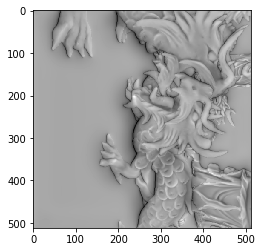

In [6]:
pic = i.squeeze(1).cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

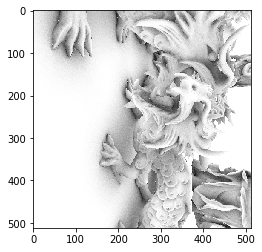

In [7]:
pic = gt.squeeze(1).cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

In [18]:
pic = exr_loader("./Position/000000000..exr", ndim=3)

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [7]:
from torchsummary import summary
print(image.size())
summary(model, (6,512,512))

torch.Size([8, 6, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]             440
         LeakyReLU-2          [-1, 8, 512, 512]               0
         AvgPool2d-3          [-1, 8, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]             592
         LeakyReLU-5         [-1, 16, 256, 256]               0
         AvgPool2d-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           1,184
         LeakyReLU-8         [-1, 32, 128, 128]               0
         AvgPool2d-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           2,368
        LeakyReLU-11           [-1, 64, 64, 64]               0
        AvgPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           4,736
        Le

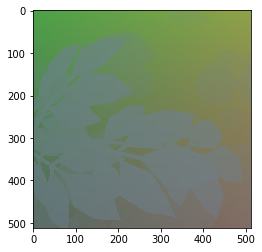

In [19]:
plt.imshow(pic)

In [24]:
# task = "AO", "GI",...
# buffers = a list of "position", "normal", "groundtruth",...
def load_train(task, buffers=None):
    result = {}
    if task == "AO":
        if buffers is None:
            buffers = ["position", "normal", "groundtruth"]
        for buffer_type in buffers:
            result[buffer_type] = load_one_file("./dataset/training_" + buffer_type + ".txt")
    return result

In [28]:
def load_one_file(filename):
    with open(filename) as f:
        images = []
        for line in f.readlines():
            path = line.split()[0]
            images.append(exr_loader(path, ndim=3)) # really 3 ??
    return np.array(images)

In [31]:
data = load_train("AO", ["groundtruth"])

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [46]:
%cd D:\Dropbox (GaTech)\CS7643 Deep Learning\DL4CG

D:\Dropbox (GaTech)\CS7643 Deep Learning\DL4CG


In [62]:
import OpenEXR
import Imath

# read image and its dataWindow to obtain its size
pic = OpenEXR.InputFile("./GI/Conference/Normals/000000000..exr")
pic.header()

{'channels': {'A': HALF (1, 1),
  'B': HALF (1, 1),
  'G': HALF (1, 1),
  'R': HALF (1, 1)},
 'compression': NO_COMPRESSION,
 'dataWindow': (0, 0) - (255, 255),
 'displayWindow': (0, 0) - (255, 255),
 'lineOrder': INCREASING_Y,
 'pixelAspectRatio': 1.0,
 'screenWindowCenter': (0.0, 0.0),
 'screenWindowWidth': 1.0}

In [67]:
# read image and its dataWindow to obtain its size
pic = OpenEXR.InputFile("./IBL/Conference/Specular/000000000..exr")
print(pic.header())

pt = Imath.PixelType(Imath.PixelType.FLOAT)
dw = pic.header()['dataWindow']
size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

pt = Imath.PixelType(Imath.PixelType.FLOAT)

channel = np.fromstring(pic.channel('B', pt), dtype=np.float32)
channel.shape = (size[1], size[0])  # Numpy arrays are (row, col)
np.array(channel)

{'channels': {'A': HALF (1, 1), 'B': HALF (1, 1), 'G': HALF (1, 1), 'R': HALF (1, 1)}, 'compression': NO_COMPRESSION, 'dataWindow': (0, 0) - (255, 255), 'displayWindow': (0, 0) - (255, 255), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 1.0}


D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


array([[0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       [0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       [0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       ...,
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ],
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ],
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ]], dtype=float32)

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


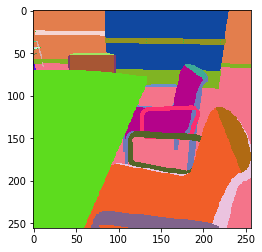

In [70]:
pic = exr_loader("./IBL/Conference/Specular/000000000..exr", ndim=3)
plt.imshow(pic)